In [84]:
from gnn_tracking.utils.log import logger
import numpy as np
from typing import Any
from torch_geometric.data import Data
from gnn_tracking.training.lw_setter import LossWeightSetterHook


class SineLWSH(LossWeightSetterHook):
    def __init__(
        self,
        loss_name: str|tuple[str, ...],
        mean: float,
        amplitude: float,
        period: int,
        amplitude_halflife: float,
        n_batches: int,
    ):
        self._loss_name = loss_name
        self._mean = mean
        self._amplitude = amplitude
        self._period = period
        self._amplitude_half_life = amplitude_halflife
        self._n_batches = n_batches

    def get_lw(self, epoch, batch_idx):
        idx = epoch * self._n_batches + batch_idx
        amplitude_decay = 0.5**(1/(self._amplitude_half_life * self._n_batches))
        amplitude = self._amplitude * amplitude_decay**idx
        s = np.sin(2*np.pi * idx / (self._period * self._n_batches))
        r = self._mean + amplitude * s
        logger.debug("Setting loss weight to %f", r)
        return r


In [101]:
lws = SineLWSH("test", 1, -1, 1, 1/3, 100)

In [102]:
import matplotlib.pyplot as plt

In [39]:
from scipy.interpolate import CubicSpline

class SmoothNStepLWSH:
    def __init__(self, steps: dict[str, float], n_batches: int):
        cs = CubicSpline(n_batches * np.array(list(steps)), list(steps.values()))
        self._steps = cs(np.arange(0, max(steps.values())*n_batches))
        print(len(self._steps))
        self._n_batches = n_batches

    def get_lw(self, epoch, batch_idx):
        idx = epoch * self._n_batches + batch_idx
        if idx >= len(self._steps):
            return self._steps[-1]
        return self._steps[idx]


In [50]:
lws = SmoothNStepLWSH({0: 0, 2: 0.5, 3: 1, 10:1}, 100)

100


In [51]:
import numpy as np
import matplotlib.pyplot as plt

In [52]:
epoch = 0
batch_idx = np.concatenate([np.arange(0, 100), np.arange(0, 100), np.arange(0, 100), np.arange(0, 100)])
epoch = np.concatenate([np.full(100, 0), np.full(100, 1), np.full(100, 2), np.full(100, 3)])


In [53]:
results = [lws.get_lw(epoch, idx) for epoch, idx in zip(epoch, batch_idx)]

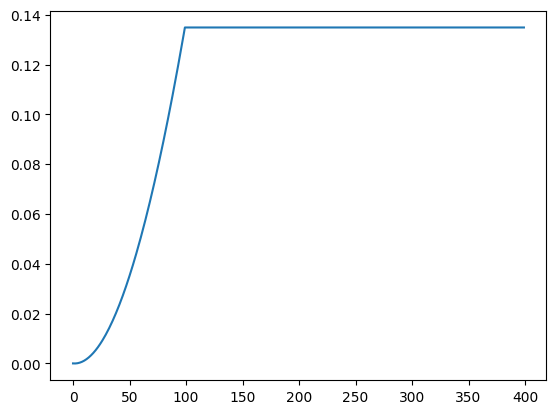

In [54]:
plt.plot(batch_idx+epoch*lws._n_batches, results)